### Import required libraries
#### This notebook uses parameter values imported from csv file
#### Written by Tim 31/5/2021
#### Saves results to csv file

In [10]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.style.use('ggplot')
from datetime import datetime



### Set input values here

In [32]:
df = pd.read_csv('inflow_params.csv', header=0, index_col = 'Parameter')
print (df)
#calcs effective pit radius
width = df.loc['pit width','value']
length = df.loc['pit length', 'value']
effectcircradius = math.sqrt(width*length/math.pi)
print ('effective radius is: ',round(effectcircradius,2), 'm')

#input parameters for pit inflow 
hp = 0
W  = df.loc['distributed recharge','value']
rp = effectcircradius
kh1 = df.loc['zone 1 horizontal K','value']
kh2 = df.loc['zone 2 horizontal K','value']
kv = df.loc ['zone 2 vertical K','value']
ani = math.sqrt(kh2/kv)
pitbase = df.loc['pit base','value']
sGWL = df.loc['static GWL','value']
h0 = sGWL - pitbase
        
print ('Anistrophy is ',round(ani,2))



                       symbol      value units  comment
Parameter                                              
pit width                   a  200.00000     m      NaN
pit length                  b  400.00000     m      NaN
distributed recharge        W    0.00010   m/d      NaN
zone 1 horizontal K        kh    0.00500   m/d  minimum
zone 2 horizontal K       kh2    0.00050   m/d      NaN
zone 2 vertical K          kv    0.00005   m/d      NaN
pit base              pitbase   10.00000  mAHD      NaN
static GWL               sGWL   60.00000  mAHD      NaN
effective radius is:  159.58 m
Anistrophy is  3.16


In [33]:
#create a dictionary of lists with headers roi and pitinflow
results = {'R0_m':[],'zone_1_pit_inflow_m3/d':[],'drawdown_m':[],'zone_2_pit_inflow_m3/d':[],
                'total_pit_inflow_m3/d':[],'pit_level_mRL':[]}

### Pit inflow model

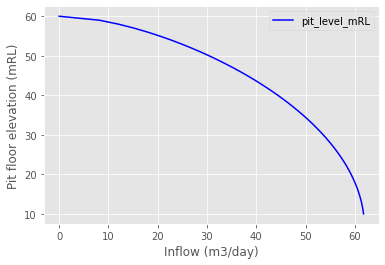

In [34]:
#iterate through r0 values to find r0 equaling h0 from input
while hp <= h0:
    r0_lower = 0.0001
    r0_upper = 100000
    erra = 100
    margin = 0.0000001
    iter = 0
    while erra > margin and iter < 1000:
        r0_mid = ((r0_upper + r0_lower) / 2)
        h0calc_m = math.sqrt(hp ** 2 + ((W / kh1) * (((r0_mid ** 2) * math.log(r0_mid / rp)) - 
                            ((r0_mid ** 2 - rp ** 2) / 2))))    
        closeEnough = math.isclose(h0,h0calc_m,rel_tol=0.000001,abs_tol=margin)
        if h0 >= h0calc_m:
            r0_lower = r0_mid
        else:
            r0_upper = r0_mid  
        
        iter = iter +1  
        
       
        if r0_mid <= 0.001:
            radiusofinfluence = r0_mid
            zone_1_pit_inflow = 0.0
            zone_2_pit_inflow = 0.0
        else:                
            radiusofinfluence = r0_mid
            zone_1_pit_inflow = W*math.pi*(radiusofinfluence**2-rp**2)
            zone_2_pit_inflow = 4*(kh2/ani)*effectcircradius*(h0-hp)
                
        total_pit_inflow = zone_1_pit_inflow + zone_2_pit_inflow
        lake_level = pitbase + hp
        
        if closeEnough is True:
            break

    # append data into list in dictionary
    results['R0_m'].append(round(radiusofinfluence,2))
    results['zone_1_pit_inflow_m3/d'].append(round(zone_1_pit_inflow,2))
    results['drawdown_m'].append(round(pitbase-hp,2))
    results['zone_2_pit_inflow_m3/d'].append(round(zone_2_pit_inflow,2))
    results['total_pit_inflow_m3/d'].append(round(total_pit_inflow,2))
    results['pit_level_mRL'].append(round(lake_level,2))

    if hp <= h0:
        hp=hp+1

    else:
        break

#name output file
K = str(kh1)
distrutedRecharge =str(W)

dt = str(datetime.now())
dt = dt.split('.')[0].replace(':','-')
output = 'K_'+ K + '_Recharge_' + distrutedRecharge+ '_pit_inflow_output_'+ dt +'.csv'

#put dictionary into dataframe and then export dataframe to .csv file
PitInflow =pd.DataFrame.from_dict(results,'columns')
PitInflow.sort_values(by='R0_m',ascending=True,inplace=True)

#results
#print(PitInflow)
#chart
#fig, ax = plt.subplots()
ax = PitInflow.plot(x='total_pit_inflow_m3/d', y='pit_level_mRL',color='blue')
ax.set_xlabel('Inflow (m3/day)')
ax.set_ylabel('Pit floor elevation (mRL)')

plt.show()

## Pit inflow calculation complete

In [26]:
#save t csv file

PitInflow.to_csv(output,sep=',',columns=['R0_m',
                                        'zone_1_pit_inflow_m3/d',
                                        'zone_2_pit_inflow_m3/d',
                                        'drawdown_m',
                                        'pit_level_mRL',
                                        'total_pit_inflow_m3/d'],
                                        header=True,index=False)
#print(PitInflow)
print ('Success - Pit inflow calculated. Results exported to',output)

Success - Pit inflow calculated. Results exported to K_0.005_Recharge_0.001_pit_inflow_output_2021-05-31 14-53-47.csv
